# Communication Channel

This example demonstrates how to create a connection from one neuronal ensemble to
another that behaves like a communication channel (that is, it transmits information
without changing it).

Network diagram:

      [Input] ---> (FPGA Ensemble) ---> [Output probe]

An abstract input signal is fed into the neural ensemble built remotely on the FPGA. The
ensemble on the FPGA encodes the input value as a pattern of neural activity. The neural
activity is then decoded back into an abstract value before being passed to the output
probe. In this example, the connection weight matrix that performs this decoding is
computed to replicate the value of the abstract input signal (i.e., the decoded output
should have the same value as the input signal).

## Step 1: Set up the Python Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import nengo

import nengo_fpga
from nengo_fpga.networks import FpgaPesEnsembleNetwork

## Step 2: Choose an FPGA Device

Define the FPGA device on which the remote FpgaPesEnsembleNetwork will run. This name
corresponds with the name in your `fpga_config` file. Recall that in the `fpga_config`
file, device names are identified by the square brackets (e.g., **[de1]** or
**[pynq]**). The names defined in your configuration file might differ from the example
below. Here, the device **de1** is being used.

In [2]:
board = "de1"  # Change this to your desired device name

## Step 3: Create the Remote FPGA Neural Ensemble

Create a remote FPGA neural ensemble (`FpgaPesEnsembleNetwork`) using the board defined
above, 50 neurons, 2 dimensions, and with no learning rate.

In [3]:
# Create a nengo network object to which we can add
# ensembles, connections, etc.
model = nengo.Network(label="Communication Channel")

with model:
    # Remote FPGA neural ensemble
    fpga_ens = FpgaPesEnsembleNetwork(
        board,  # The board to use (from above)
        n_neurons=50,  # The number of neurons to use in the ensemble
        dimensions=2,  # 2 dimensions, to represent a 2D vector
        learning_rate=0,  # No learning for this example
    )

    # Uncomment the following line to use spiking neuron
    # fpga_ens.ensemble.neuron_type = nengo.SpikingRectifiedLinear()

Specified FPGA configuration 'de1' not found.


## Step 4: Provide Input to the Ensemble

Create an input node that generates a 2-dimensional signal -- where the first dimension
is a sine wave, and the second dimension a cosine wave.

In [4]:
def input_func(t):
    return [np.sin(t * 2 * np.pi), np.cos(t * 2 * np.pi)]


with model:
    input_node = nengo.Node(input_func)

## Step 5: Connect the Input to the FPGA Ensemble

The FPGA ensemble contains `input` and `output` attributes to allow connections to be
made to and from the ensemble.

In [5]:
with model:
    # Connect the input to the FPGA ensemble
    nengo.Connection(input_node, fpga_ens.input)

## Step 6: Add Probes to Collect Data

Even this simple model involves many quantities that change over time, such as membrane
potentials of individual neurons. Typically there are so many variables in a simulation
that it is not practical to store them all. If we want to plot or analyze data from the
simulation we have to "probe" the signals of interest.

Many of the internal dynamics of the FPGA ensemble are not probeable since collecting
and transmitting all of these values would slow down the simulation considerably.
However, the input and output of the FPGA ensemble are available, and are enough to
illustrate the network functionality.

In [6]:
with model:
    # The original input
    input_p = nengo.Probe(input_node, synapse=0.01)

    # The output from the FPGA ensemble
    # (filtered with a 10ms post-synaptic filter)
    output_p = nengo.Probe(fpga_ens.output, synapse=0.01)

## Step 7: Run the Model!

To run a NengoFPGA model, simply use the `nengo_fpga.Simulator` simulator instead of the
standard `nengo.Simulator` simulator.

In [7]:
with nengo_fpga.Simulator(model) as sim:
    sim.run(2)  # Run for 2 seconds

Building network with dummy (non-FPGA) ensemble.


## Step 8: Plot the Results

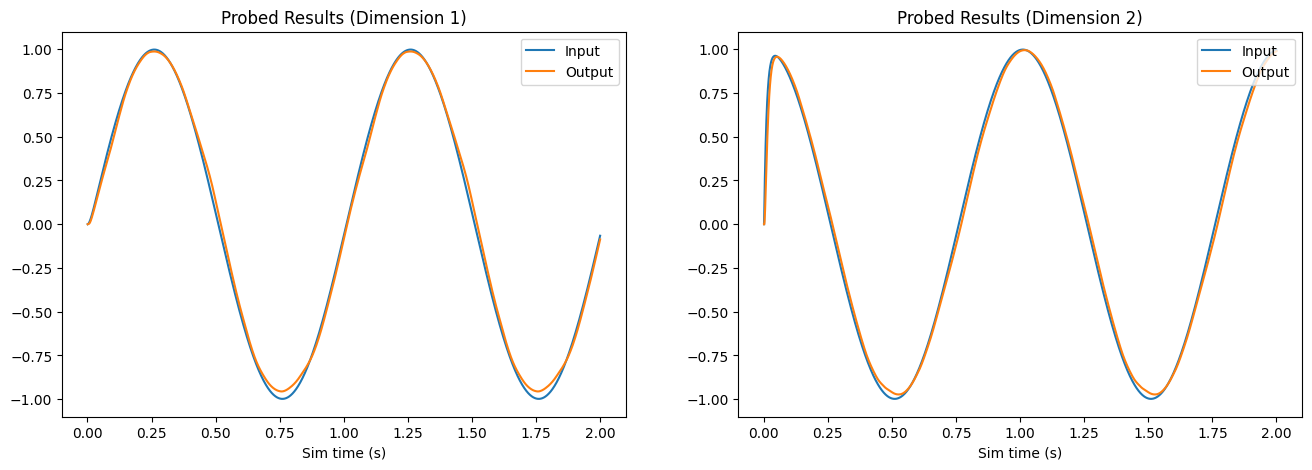

In [8]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.title("Probed Results (Dimension 1)")
plt.plot(sim.trange(), sim.data[input_p][:, 0])
plt.plot(sim.trange(), sim.data[output_p][:, 0])
plt.ylim(-1.1, 1.1)
plt.legend(("Input", "Output"), loc="upper right")
plt.xlabel("Sim time (s)")

plt.subplot(1, 2, 2)
plt.title("Probed Results (Dimension 2)")
plt.plot(sim.trange(), sim.data[input_p][:, 1])
plt.plot(sim.trange(), sim.data[output_p][:, 1])
plt.ylim(-1.1, 1.1)
plt.legend(("Input", "Output"), loc="upper right")
plt.xlabel("Sim time (s)")

plt.show()

The plot above compares each dimension of the input (reference) signal (in blue) with
the probed output of the FPGA ensemble (in orange). As the plot illustrates, the decoded
neural activity of the FPGA ensemble is able to replicate the input signal with only a
slight temporal delay.

## Step 9: Experiment with this Model

Using this Jupyter notebook, it is possible to experiment with the various parameters of
the FPGA ensemble to observe how they affect the behaviour of the ensemble. Note that
the experiments below require you to run this notebook within the Jupyter ecosystem. If
you are viewing this via the NengoFPGA documentations page, please clone the NengoFPGA
repository to perform these experiments.

### Input Function

Try changing the input function (`input_func`) above. As long as the function outputs a
2-dimensional value the model should work but you may see the reconstructed signal
deteriorate as the range and frequency of your input function increase.

### Neuron Type

By default, NengoFPGA uses Rectified Linear Units (ReLU) neurons to simulate the neurons
in the FPGA neural ensemble. NengoFPGA also supports Spiking Rectified Linear units,
also known as Integrate and Fire (IF) neurons. To use these neurons, uncomment the line
noted in the Step 3 above (`fpga_ens.ensemble.neuron_type`).